<a href="https://colab.research.google.com/github/peterbabulik/synthetic/blob/main/Sierpinski.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Original data: b'Hello, Sierpinski! This is a test of error correction using GPU acceleration.'
Decoded data: b'Hello, Sierpinski! This is a test of error correction using GPU acceleration.\x9c'
Storage Capacity with Error Correction: 7381 bytes (100745.46 bits)
Execution time: 30.23 seconds


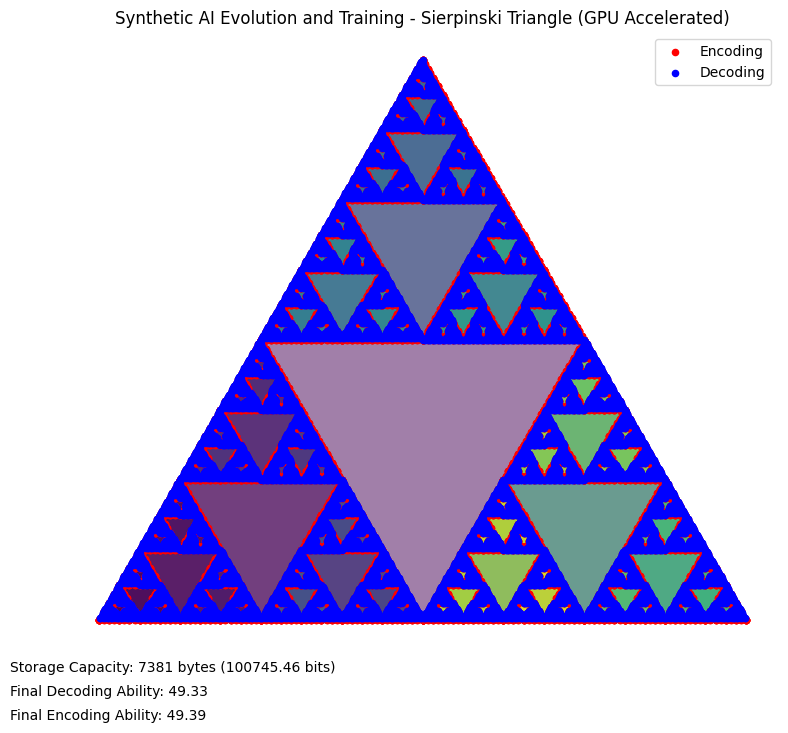

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/sierpinski_ai_evolution.png'

In [4]:
import matplotlib.pyplot as plt
import random
import numpy as np
import math
import torch
import time
from google.colab import drive

# Mount Google Drive (optional, if you want to save results)
# drive.mount('/content/drive')

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class SyntheticAI:
    def __init__(self):
        self.encoding_ability = torch.tensor([0.0], device=device)
        self.decoding_ability = torch.tensor([0.0], device=device)

    def train(self):
        self.encoding_ability += torch.rand(1, device=device) * 0.01
        self.decoding_ability += torch.rand(1, device=device) * 0.01

    def encode(self, data):
        return (data + self.encoding_ability) % 256

    def decode(self, encoded_data):
        return (encoded_data - self.decoding_ability) % 256

def midpoint(p1, p2):
    return ((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)

def sierpinski(points, degree, ai):
    triangles = []
    encode_points = []
    decode_points = []

    def sierpinski_recursive(points, degree):
        if degree > 0:
            ai.train()
            triangles.append(points)
            encode_points.append(points[0])
            decode_points.append(points[1])

            sierpinski_recursive([points[0],
                                  midpoint(points[0], points[1]),
                                  midpoint(points[0], points[2])],
                                 degree - 1)
            sierpinski_recursive([points[1],
                                  midpoint(points[0], points[1]),
                                  midpoint(points[1], points[2])],
                                 degree - 1)
            sierpinski_recursive([points[2],
                                  midpoint(points[2], points[1]),
                                  midpoint(points[0], points[2])],
                                 degree - 1)
        else:
            triangles.append(points)

    sierpinski_recursive(points, degree)
    return triangles, encode_points, decode_points

def plot_sierpinski(triangles, encode_points, decode_points):
    fig, ax = plt.subplots(figsize=(10, 8))

    for i, t in enumerate(triangles):
        color = plt.cm.viridis(i / len(triangles))
        ax.fill([p[0] for p in t] + [t[0][0]],
                [p[1] for p in t] + [t[0][1]],
                facecolor=color, edgecolor='none', alpha=0.5)

    encode_x, encode_y = zip(*encode_points)
    decode_x, decode_y = zip(*decode_points)

    ax.scatter(encode_x, encode_y, c='red', s=20, label='Encoding')
    ax.scatter(decode_x, decode_y, c='blue', s=20, label='Decoding')

    ax.set_aspect('equal')
    ax.axis('off')
    plt.legend()
    plt.title("Synthetic AI Evolution and Training - Sierpinski Triangle (GPU Accelerated)")
    return fig

def calculate_checksum(data):
    return torch.sum(data) % 256

def encode_data_with_error_correction(data, triangles, ai):
    data_tensor = torch.tensor([int(b) for b in data], dtype=torch.float32, device=device)
    encoded_data = []
    chunk_size = 3  # Store each byte 3 times for redundancy
    for i in range(0, len(data_tensor), chunk_size):
        chunk = data_tensor[i:i+chunk_size]
        checksum = calculate_checksum(chunk)
        for byte in chunk:
            if len(encoded_data) < len(triangles):
                encoded_value = ai.encode(byte)
                encoded_data.extend([(triangles[len(encoded_data)], encoded_value)] * 3)  # Store 3 times
        if len(encoded_data) < len(triangles):
            encoded_data.append((triangles[len(encoded_data)], ai.encode(checksum)))
    return encoded_data

def decode_data_with_error_correction(encoded_data, ai):
    decoded_data = []
    chunk_size = 3
    for i in range(0, len(encoded_data), chunk_size * 3 + 1):  # 3 repetitions + 1 checksum
        chunk = encoded_data[i:i+chunk_size*3]
        checksum_encoded = encoded_data[i+chunk_size*3][1] if i+chunk_size*3 < len(encoded_data) else None

        # Decode each byte (taking average of 3 repetitions)
        for j in range(0, len(chunk), 3):
            byte_values = [ai.decode(chunk[j+k][1]).item() for k in range(3) if j+k < len(chunk)]
            decoded_byte = int(sum(byte_values) / len(byte_values))
            decoded_data.append(decoded_byte)

        # Verify checksum
        if checksum_encoded is not None:
            calculated_checksum = calculate_checksum(torch.tensor(decoded_data[-chunk_size:], device=device))
            decoded_checksum = int(ai.decode(checksum_encoded).item())
            if calculated_checksum != decoded_checksum:
                print(f"Checksum mismatch at chunk {i//chunk_size//3}. Data might be corrupted.")

    return bytes(decoded_data)

def calculate_storage_capacity(triangles, ai):
    total_triangles = len(triangles)
    usable_triangles = total_triangles * 3 // 4  # 1/4 of triangles used for checksums
    byte_capacity = usable_triangles // 3  # Each byte stored 3 times

    max_value = 255 * (1 + ai.encoding_ability.item())
    bit_capacity = byte_capacity * math.log2(max_value)

    return byte_capacity, bit_capacity

def main():
    iterations = 9 # Increased for a more complex structure
    points = [(0, 0), (0.5, np.sqrt(3)/2), (1, 0)]

    start_time = time.time()

    ai = SyntheticAI()
    triangles, encode_points, decode_points = sierpinski(points, iterations, ai)

    fig = plot_sierpinski(triangles, encode_points, decode_points)

    byte_capacity, bit_capacity = calculate_storage_capacity(triangles, ai)

    plt.figtext(0.1, 0.02, f"Final Encoding Ability: {ai.encoding_ability.item():.2f}", fontsize=10)
    plt.figtext(0.1, 0.05, f"Final Decoding Ability: {ai.decoding_ability.item():.2f}", fontsize=10)
    plt.figtext(0.1, 0.08, f"Storage Capacity: {byte_capacity} bytes ({bit_capacity:.2f} bits)", fontsize=10)

    # Example of encoding and decoding data with error correction
    sample_data = b"Hello, Sierpinski! This is a test of error correction using GPU acceleration."
    encoded_data = encode_data_with_error_correction(sample_data, triangles, ai)
    decoded_data = decode_data_with_error_correction(encoded_data, ai)

    end_time = time.time()
    execution_time = end_time - start_time

    print(f"Original data: {sample_data}")
    print(f"Decoded data: {decoded_data}")
    print(f"Storage Capacity with Error Correction: {byte_capacity} bytes ({bit_capacity:.2f} bits)")
    print(f"Execution time: {execution_time:.2f} seconds")

    plt.show()

    # Optional: Save the figure to Google Drive
    fig.savefig('/content/drive/My Drive/sierpinski_ai_evolution.png')

if __name__ == "__main__":
    main()

# To run this code, simply execute this cell.
# Make sure you've selected GPU as the runtime type in Colab:
# Runtime > Change runtime type > Hardware accelerator > GPU